# Optimizing HERMES
HERMES is a hybrid integrator that is capable of accurately resolving close encounters and collisions. It is a very powerful tool for a large number of problems, but does require some optimization by the user in order to find the optimal balance of speed and accuracy.  

The two main parameters that need to be optimized are the hybrid switch radius ($HSR$) and the time step ($dt$). $HSR$ defines the close encounter region inside of which the IAS15 algorithm takes over, and $dt$ controls how far a particle can travel between successive close encounter checks. If these values are incorrectly chosen the integrator will certainly still run, but either your energy error will be too large or the integration will take much longer than it needs to. As a rough rule of thumb you should aim for: 
\begin{equation}
dt \sim \frac{HSR*r_{hill,cmb}}{dv_{max}} 
\end{equation}
where $dv_{max}$ is the max relative velocity between your planet and planetesimal over the course of a simulation and $r_{hill,cmb}$ is the combined hill radius of your planet and planetesimal (can be approximated as just the planet's hill radius if participating bodies in the close encounter are small).  


Each specific problem will have its own optimal combination of $dt$ and $HSR$. Here we provide a general recipe for optimizing HERMES using the example of a planet embedded in a disk of planetesimals.

In [1]:
import rebound
import numpy as np

### Functions
For this tutorial we'll need to make use of quite a few different functions, which we will build up from scratch. The first set of functions we'll need are different distributions for drawing orbital parameters.

In [2]:
def rand_powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum

def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

Next we need a function that can check whether $dt$ and $HSR$ are sufficient to efficiently capture and resolve close encounters, i.e. using the equation above. The function created below, "check_for_bad_dt", accomplishes this goal, but it turns out rebound already checks for this each iteration, returning a "timestep_too_large" flag if it is a bad region of ($dt$, $HSR$) parameter space.

In [3]:
def check_for_bad_dt(sim):
    bad_dt = 0
    
    par = sim.particles
    p0 = sim.particles[0]                                      #star
    p = sim.particles[sim.N_active]                            #planet
    dx = p.x - p0.x
    dy = p.y - p0.y
    dz = p.z - p0.z
    mh = (p.m/(3*p0.m))**(1./3.)
    rhill_p = mh*(dx*dx + dy*dy + dz*dz)**(0.5)               #hill radius planet
    vmax = 0                                                  #max relative velocity squared
    for i in xrange(sim.N_active,sim.N):
        dx_i = par[i].x - p0.x
        dy_i = par[i].y - p0.y
        dz_i = par[i].z - p0.z
        mh_i = (par[i].m/(3*p0.m))**(1./3.)
        rhill_p_i = mh_i*(dx_i*dx_i + dy_i*dy_i + dz_i*dz_i)**(0.5)
        rh_sum = rhill_p + rhill_p_i
        dvx = par[i].vx - p.vx
        dvy = par[i].vy - p.vy
        dvz = par[i].vz - p.vz
        v = (dvx*dvx + dvy*dvy + dvz*dvz)**(0.5)
        if v > vmax:
            vmax = v
    HSR = sim.ri_hybarid.switch_radius
    min_dt = HSR*rh_sum / vmax
    if(min_dt < 4*sim.dt):
        bad_dt = 1                                           #factor of 4 for extra wiggle room
    return bad_dt

### Problem
Next let's quickly create a test problem which simulates a single Earth-sized planet embedded in a disk of planetesimals, allowing for collisions, ejections and close encounters. This problem is very similar to the "Primordial Earth" example.

In [14]:
import time as timing
def problem(HSR, dt, tmax):
    sim = rebound.Simulation()
    
    #integrator options
    sim.integrator = "hybarid"
    sim.ri_hybarid.switch_radius = HSR
    sim.ri_hybarid.CE_radius = 20.
    sim.dt = dt
    sim.testparticle_type = 1   #if set to 0, they become test bodies.
    sim.usleep = 1000

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = "merge"
    sim.boundary = "open"
    boxsize = 3.
    sim.configure_box(boxsize)
    sim.collisions_track_dE = 1
    
    #sun
    sim.add(m=1., r=0.005)
    
    #planet
    a_p = 0.5
    sim.add(m=3e-6,r=5e-5,a=a_p,e=0.01)
    
    sim.N_active = sim.N
    
    #Planetesimals
    N_pl = 500
    m_pl = 1e-9
    r_pl = 1.1e-5
    while sim.N < (N_pl + sim.N_active):
        a = rand_powerlaw(0, a_p-0.03, a_p+0.03)
        e = rand_rayleigh(0.01)
        inc = rand_rayleigh(0.05)
        Omega = rand_uniform(0,2*np.pi)
        omega = rand_uniform(0,2*np.pi)
        f = rand_uniform(0,2*np.pi)
        sim.add(m=m_pl, r=r_pl, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f)
    
    #Final initializations
    sim.move_to_com()
    E0 = sim.calculate_energy()
    
    #integrate, keeping track of elapsed time
    start_t = timing.time()
    sim.integrate(tmax)
    time = timing.time() - start_t
    
    #Final processing
    #bad_dt = check_for_bad_dt(sim)
    bad_dt = sim.ri_hybarid.timestep_too_large_warning
    dE = abs((sim.calculate_energy() - E0)/E0)
    
    return HSR, dt, dE, bad_dt, time

In [15]:
problem(0.0001,0.5,100)

(0.0001, 0.5, 2.7148447756747795e-05, 1, 0.4553210735321045)

Great! Now, let's create a grid search function to efficiently sample the parameter space of interest. To avoid this taking a long time we'll use a relatively short simulation time.

In [10]:
np.random.RandomState(42)

n_trials = 50
simulation_time = 10             #Use at least a few orbital periods
dt = np.logspace(-4,0,n_trials) #min/max limits in logspace, i.e. 10**min - 10**max.
HSR = np.logspace(0,1.5,n_trials) #min/max limits in logspace, i.e. 10**min - 10**max.  

#fill arrays - randomize dt array for efficient grid search
params = zip(HSR,np.random.permutation(dt),np.ones(n_trials)*simulation_time)

### Calculate
Calculate the results. **Warning!** This might take a while.

In [14]:
#Find error growth as a function of HSR
import multiprocessing as mp
import pandas as pd

def execute(pars):
    return problem(pars[0],pars[1],pars[2])

if __name__== '__main__':
    results = []
    pool = mp.Pool(processes=len(params))
    results.append(pool.map(execute, params))
    pool.close()
    pool.join()
    data = pd.DataFrame(results[0],columns=["HSR","dt","dE","bad_dt","elapsed_time"])

### Analyze
Great! Now let's plot the results.

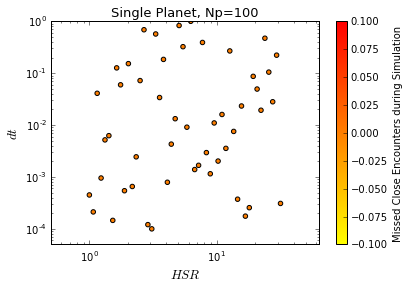

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(data["HSR"], data["dt"], c=data["bad_dt"], cmap="autumn_r")
cbar = plt.colorbar()
size=13
cbar.set_label("Missed Close Encounters during Simulation",size=10)
plt.xlabel('$HSR$',fontsize=size)
plt.ylabel('$dt$',fontsize=size)
plt.ylim([0.5*data["dt"].min(), data["dt"].max()])
plt.xlim([0.5,2*data["HSR"].max()])
plt.yscale('log')
plt.xscale('log')
plt.savefig("Parameter_Search_goodbad_C.pdf")

The red points indicate regions of parameter space where close encounters will be missed, leading to a loss of accuracy and inaccurate results. The yellow points correspond to desirable regions of parameter space where the physics of the problem will be accurately captured. 

### Quick Detour to Machine Learning Land
Although one can tell fairly easily by eye where the boundary is between good and bad points, let's formalize this process using a support vector machine (SVM) to statistically find this boundary. First we need to transform the data so that both parameters have similar ranges and are on the same scale.

In [ ]:
from sklearn.preprocessing import StandardScaler
y=data["bad_dt"]
data["logdt"] = np.log10(data["dt"])  #convert log axis to linear
Xcolumns = ["HSR","logdt"]
XX = data[Xcolumns]
scaler = StandardScaler().fit(X)
X = scaler.transform(XX)

Now let's find the boundary.

In [ ]:
from sklearn.svm import SVC
clf=SVC(kernel='linear',C=10)
clf.fit(X,y);

That was easy! Let's plot the data along with our SVM boundary and supporting vectors.

In [ ]:
#Get SVM coefficients
w=clf.coef_[0]
a=-w[0]/w[1]

#sample the SVM boundary and transform back to original co-ords
x,y = zip(*X)
xx = np.linspace(min(x),max(x))
yy=a*xx-(clf.intercept_[0])/w[1]
xx,yy = zip(*scaler.inverse_transform(zip(xx,yy)))

#get support vectors and transform back to original coords
supx, supy = zip(*scaler.inverse_transform(zip(clf.support_vectors_[:,0],clf.support_vectors_[:,1])))

#plot
plt.plot(xx,yy,'k-',linewidth=2)
plt.scatter(data["HSR"], data["logdt"], c=data["bad_dt"], cmap="autumn_r")
cbar = plt.colorbar()
cbar.set_label("Missed Close Encounters during Simulation",size=10)
plt.scatter(supx,supy,s=80,facecolors='none')
plt.xscale('log')
plt.xlim([0.5,10**HSR[1]])
plt.xlabel("$HSR$",fontsize=size)
plt.ylabel("log$_{10}$($dt$)",fontsize=size)

The power of the support vector machine comes from its ability to predict new data. For example, testing whether a new combination of [HSR,log(dt)] would yield a positive [0] or negative [1] result is easy!

In [ ]:
new = np.array([60,-2])

print "Using SVM, HSR="+str(new[0])+", log(dt)="+str(new[1])+" yields:",clf.predict(scaler.transform(new))[0]

### Finding the Optimal Parameters
The optimal set of parameters yield a great energy error and complete in the shortest amount of time. They will typically lie somewhere close to the support vector boundary. Let's figure out which of our good simulations ran the fastest with a good final energy error!

In [ ]:
dgood = data[(data["bad_dt"]==0) & (data["dE"]<1e-9)]
dgood = dgood.sort_values(by="elapsed_time")
dgood.head()

We can see that for this particular problem there are a number of great ($dt$, $HSR$) pairs with a good energy error.  Of course, this energy will grow over time, but it's great to start with as low of an energy error as possible!  

Making the final ($dt$, $HSR$) choice will require some human intuition. Here are a few situations that might guide your choice:
* Perhaps you want to pick the smallest $HSR$ to avoid excessive IAS15 use.
* Perhaps you want to pick a larger $HSR$ to capture complex close encounters which your forsee occurring later in your simulation.
* Perhaps you want to pick a smaller $dt$ since you expect eccentricities to grow significantly, increasing the relative velocities between bodies and requiring increased resolution.



Let's make one final plot displaying $HSR$ and $dt$ as a function of elapsed time for our good ($dt$, $HSR$) pairs.

In [ ]:
plt.scatter(dgood["elapsed_time"],dgood["dt"],c=dgood["HSR"], cmap="rainbow")
cbar = plt.colorbar()
cbar.set_label("$HSR$",size=10)
plt.yscale('log')
plt.ylim([1e-6,1])
plt.xscale('log')
plt.ylabel("$dt$",fontsize=size)
plt.xlabel("elapsed time (seconds)",fontsize=size)
plt.title('Single Planet, Np=50',fontsize=size)